**About** : This notebook is used to infer models.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cd ../src/

/home/tviel/work/kaggle_birdclef_2024/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Imports

In [4]:
import os
import gc
import sys
import cv2
import glob
import json
import torch
import shutil
import joblib
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import expit
from joblib import Parallel, delayed

warnings.simplefilter(action="ignore", category=UserWarning)

In [5]:
from util.logger import Config
from util.metrics import macro_auc
from util.torch import load_model_weights

from data.preparation import prepare_data, prepare_folds
from model_zoo.models import define_model
from inference.predict import infer_onnx, load_sample, infer_sample
from params import CLASSES

### Params

In [6]:
EVAL = False

In [7]:
if EVAL:
    DATA_PATH = "../input/train_audio/"
else:
    DATA_PATH = "../input/unlabeled_soundscapes/"

In [8]:
BATCH_SIZE = 48
USE_FP16 = True
NUM_WORKERS = 4

DEVICE = "cuda"

DURATION = 5
SR = 32000

### Preprocessing

In [10]:
if EVAL:
    df = pd.DataFrame({"path": glob.glob(DATA_PATH + "*/*")})
    df["id"] = df["path"].apply(lambda x: x.split("/")[-1][:-4])

    folds = pd.read_csv('../input/folds_4.csv')
    folds['id'] = folds['filename'].apply(lambda x: x.split('/')[-1][:-4])
    df = df.merge(folds)
    df = df[df['fold'] == 0].reset_index(drop=True)

    df["primary_label"] = df["path"].apply(lambda x:  x.split('/')[-2])
else:
    df = pd.DataFrame({"path": glob.glob(DATA_PATH + "*")})
    df["id"] = df["path"].apply(lambda x: x.split("/")[-1][:-4])
    
    # df["duration"] = df["path"].apply(lambda x: librosa.get_duration(path=x))
    # df = df[df["duration"] != 240].reset_index(drop=True)

### Models

In [11]:
cd ../../BirdNET-Analyzer/

/home/tviel/work/BirdNET-Analyzer


In [28]:
DATA_PATH = "../kaggle_birdclef_2024/input/"

In [ ]:
mapping = pd.read_csv(DATA_PATH + "eBird_Taxonomy_v2021.csv")

In [ ]:
import pickle

with open(DATA_PATH + '../output/cpmp_preds_72/pl_all.pkl', "rb") as f:
    preds_ = pickle.load(f)

preds_cpmp = {}
for k in preds_.keys():
    preds_cpmp[k[:-4].split('/')[-1]] = np.mean(preds[k], 0)

del preds_
gc.collect()

7046

In [ ]:
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime
import skimage
import re

# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

In [151]:
DATA_PATH

'../kaggle_birdclef_2024/input/'

In [157]:
# !python analyze.py --i /home/tviel/work/kaggle_birdclef_2024/input/unlabeled_soundscapes/ --o /home/tviel/work/kaggle_birdclef_2024/output/birdnet  --threads 32 --batchsize 64 --min_conf 0.01 --rtype csv --skip_existing_results

In [186]:
def infer_sample(path, analyzer=None, out_path=None):
    if out_path is None:
        recording = Recording(
            analyzer,
            path,
            min_conf=0.01,
        )
        recording.analyze()
        dets = recording.detections
    else:
        dets = pd.read_csv(out_path)
        dets.columns = ['start_time', 'end_time', 'scientific_name', 'common_name', 'confidence']
        dets = dets.to_dict(orient="index").values()

    d = librosa.get_duration(path=path)
    preds = np.zeros((int(np.ceil(d / 3)), 182))

    for r in dets:
        # print(r)

        m = mapping[mapping["PRIMARY_COM_NAME"] == r["common_name"]]
        m = mapping[mapping["SCI_NAME"] == r["scientific_name"]]
        try:
            code = m["SPECIES_CODE"].values[0]
        except:
            # m = mapping[mapping["SCI_NAME"] == r["scientific_name"]]
            # try:
            #     code = m["SPECIES_CODE"].values[0]
            # except:
            continue

        if code in CLASSES:
            start = int(r["start_time"] // 3)
            end = int(r["end_time"] // 3 + 1)

            preds[start: end, CLASSES.index(code)] = max(r["confidence"], preds[start: end, CLASSES.index(code)].max())
        # break    

    preds = skimage.transform.resize(preds[None], (1, np.ceil(d / 5)))[0]
    return preds

In [189]:
all_preds = joblib.Parallel(n_jobs=os.cpu_count())(
    joblib.delayed(infer_sample)(
        DATA_PATH + df["path"][idx],
        None,
        "/home/tviel/work/kaggle_birdclef_2024/output/birdnet/" + df["id"][idx] + '.BirdNET.results.csv'
    )
    for idx in tqdm(range(len(df)))
)


  0%|          | 0/8444 [00:00<?, ?it/s]

In [190]:
all_preds = dict(zip(df["id"].values, all_preds))

In [193]:
with open('/home/tviel/work/kaggle_birdclef_2024/output/birdnet_preds.pkl', 'wb') as f:
    pickle.dump(all_preds, f, protocol=pickle.HIGHEST_PROTOCOL)

In [195]:
df.id.values[:10]

array(['184575141', '1542255759', '1976786596', '106748716', '523220948',
       '616589570', '95561326', '1908248554', '901569271', '1681605492'],
      dtype=object)

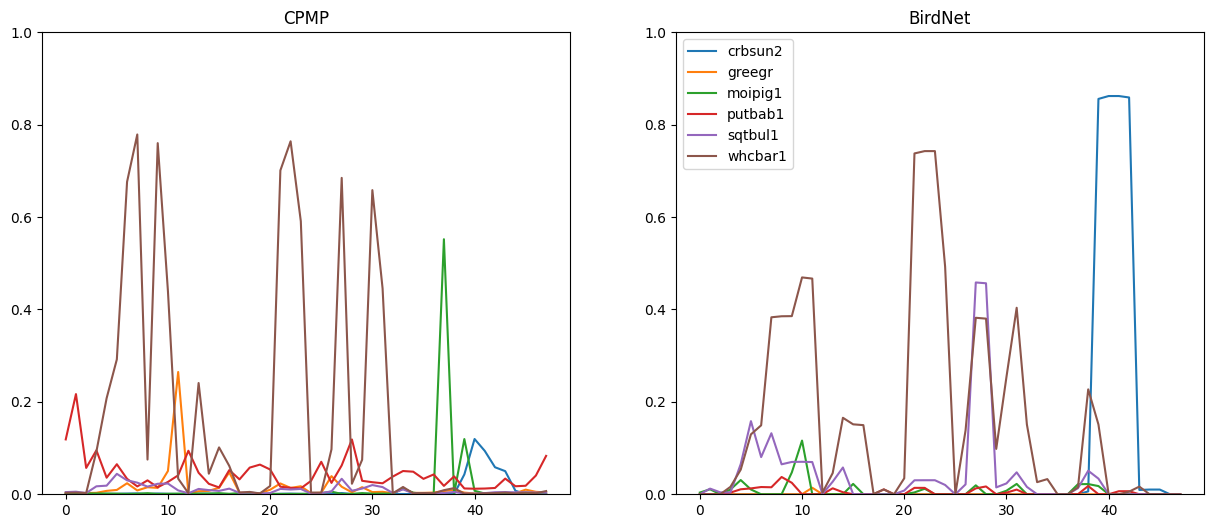

In [192]:
for idx in range(10):
    # preds = infer_sample(
    #     DATA_PATH + df.path[idx],
    #     analyzer,
    # )

    # preds = infer_sample(
    #     DATA_PATH + df["path"][idx],
    #     None,
    #     "/home/tviel/work/kaggle_birdclef_2024/output/birdnet/" + df["id"][idx] + '.BirdNET.results.csv'
    # )

    p = preds_cpmp[df.id[idx]]
    preds = all_preds[df.id[idx]]

    plt.figure(figsize=(15, 6))
    for i, c in enumerate(CLASSES):
        if p[:, i].max() > th or preds[:, i].max() > th:
            plt.subplot(1, 2, 1)
            plt.plot(p[:, i], label=c)
            plt.ylim(0, 1)
            plt.title(f'CPMP')

            plt.subplot(1, 2, 2)
            plt.plot(preds[:, i], label=c)
            plt.ylim(0, 1)
            plt.title(f'BirdNet')

    plt.legend()
    plt.show()

    break

Done !